In [280]:
import mlflow
from mlflow.tracking import MlflowClient

import os
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sktools import GradientBoostingFeatureGenerator

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

from xgboost import XGBClassifier

# Load Dataset

In [281]:
train_data = pd.read_csv('data/train.csv', index_col=0)
test_data = pd.read_csv('data/test.csv', index_col=0)
train_data.info()
display(pd.DataFrame({'% of NANs': round(train_data.isna().sum() * 100 / len(train_data))}))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


,% of NANs
Survived,0.0
Pclass,0.0
Name,0.0
Sex,0.0
Age,20.0
SibSp,0.0
Parch,0.0
Ticket,0.0
Fare,0.0
Cabin,77.0


# Descriptive Analysis

In [282]:
train_data.describe(percentiles=[0.25, 0.5, 0.75, 0.95])

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
95%,1.000000,3.000000,56.000000,3.000000,2.000000,112.079150
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [283]:
# Survived column values
print("Value counts for `Survived` column")
display(train_data.Survived.value_counts())

Value counts for `Survived` column


0    549
1    342
Name: Survived, dtype: int64

In terms of Gender, the dataset seems to be reasonably balanced. 

Survivability for Women was higher than for men

In [284]:
print('Gender value percentage:\n')
display(train_data.Sex.value_counts() / len(train_data))

print("Survival percentage for each gender:\n")

women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

Gender value percentage:



male      0.647587
female    0.352413
Name: Sex, dtype: float64

Survival percentage for each gender:

% of women who survived: 0.7420382165605095
% of men who survived: 0.18890814558058924


# Visual Analysis

The majority of passengers who paid more suvived

<AxesSubplot:xlabel='Fare', ylabel='Age'>

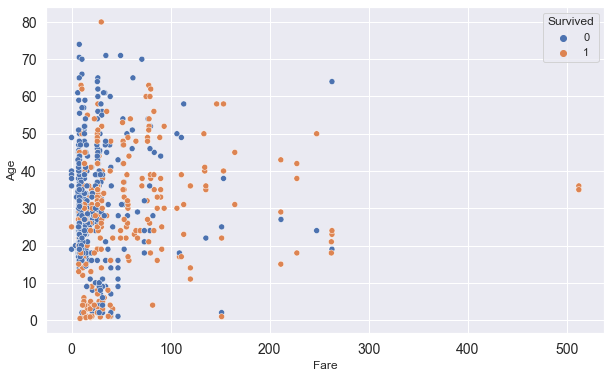

In [285]:
sns.scatterplot(x='Fare', y='Age', data=train_data, hue='Survived')

Midle Aged passengers were the most common.

Ages under adults have highest survival percentages

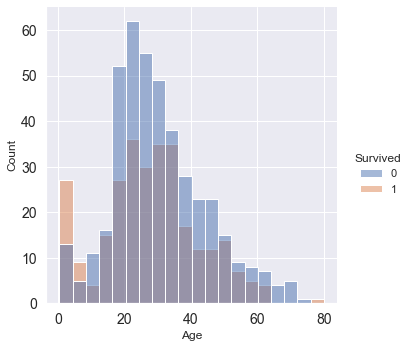

In [286]:
sns.displot(data=train_data, x='Age', hue='Survived')

<AxesSubplot:xlabel='Age_Category', ylabel='count'>

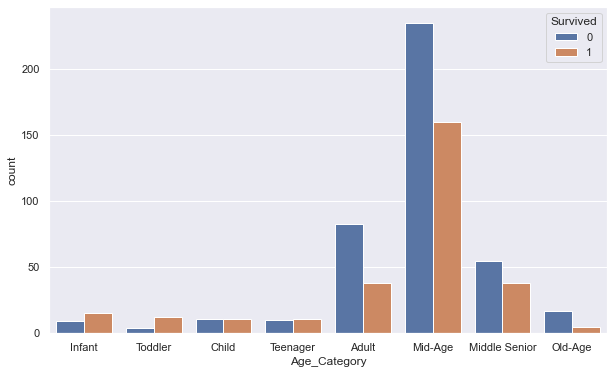

In [287]:
visualize_age = train_data[['Age', 'Survived', 'Ticket']].copy()
visualize_age['Age_Category'] = pd.cut(
    x=visualize_age.Age, 
    bins=[0, 2, 4, 9, 15, 21, 44, 60, 80], 
    labels=['Infant', 'Toddler', 'Child', 'Teenager', 'Adult', 'Mid-Age', 'Middle Senior', 'Old-Age'], 
    include_lowest=True)

sns.set(rc={'figure.figsize':(10, 6)})
sns.countplot(x='Age_Category', data=visualize_age, hue='Survived')

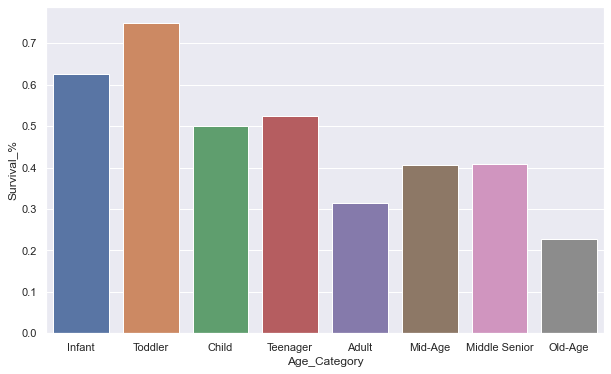

In [288]:
age_survival_perc = pd.pivot_table(columns=['Survived'], index='Age_Category', values='Ticket', aggfunc='count', data=visualize_age)
age_survival_perc = age_survival_perc.div(age_survival_perc.sum(axis=1), axis=0)
age_survival_perc.columns = ['Died', 'Survival_%']
sns.barplot(x='Age_Category', y='Survival_%', data=age_survival_perc.reset_index())
plt.show()

Passenger class 1 had the largest Survival percentage, and Passenger class 3 had the lowest. 

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

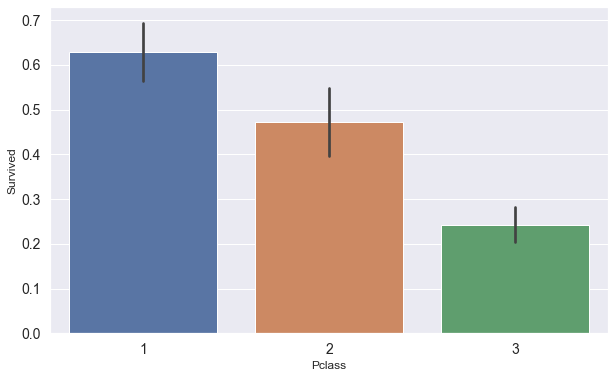

In [289]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

sns.barplot(x='Pclass', y='Survived', data=train_data)

<AxesSubplot:xlabel='Pclass', ylabel='Survival_%'>

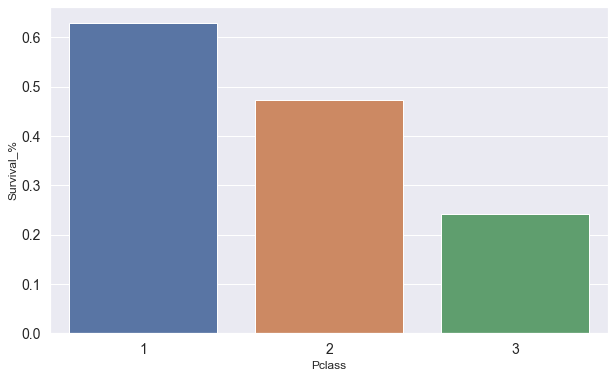

In [290]:
class_survival_perc = pd.pivot_table(columns=['Survived'], index='Pclass', values='Ticket', aggfunc='count', data=train_data)
class_survival_perc = class_survival_perc.div(class_survival_perc.sum(axis=1), axis=0)
class_survival_perc.columns = ['Died', 'Survival_%']
sns.barplot(x='Pclass', y='Survival_%', data=class_survival_perc.reset_index())

## Parch (N_Parents / N_Children) - SibSp(Siblings / Spouses)
Most survivors were travelling alone 

<AxesSubplot:xlabel='SibSp', ylabel='count'>

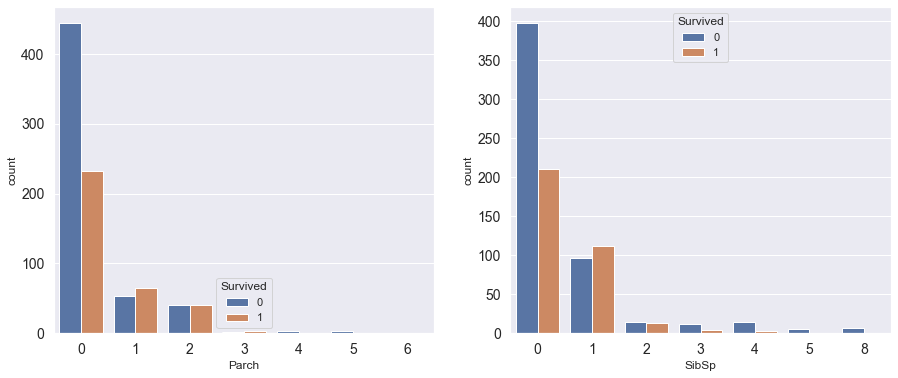

In [291]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.countplot(x='Parch', data=train_data, hue='Survived', ax=axs[0])
sns.countplot(x='SibSp', data=train_data, hue='Survived', ax=axs[1])

In [292]:
# def prepare_data(data):
#     data.drop(columns=['Name', 'Cabin', 'Ticket'], inplace=True)
#     data['Age'] = data['Age'].fillna(data['Age'].mean())
#     data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

#     data['family_size'] = data['SibSp'] + data['Parch']
#     data.loc[data['family_size'] > 0, 'is_alone'] = 0
#     data.loc[data['family_size'] == 0, 'is_alone'] = 1
#     data = data.drop('family_size', axis=1)

#     data['Age_Category'] = pd.cut(
#     x=data.Age, 
#     bins=[0, 2, 4, 9, 15, 21, 44, 60, 80], 
#     labels=['Infant', 'Toddler', 'Child', 'Teenager', 'Adult', 'Mid-Age', 'Middle Senior', 'Old-Age'], 
#     include_lowest=True)

#     data['family_size'] = data[['SibSp', 'Parch']].sum(axis=1)
#     data['isalone'] = 0
#     data.loc[(data['family_size'] == 0), 'isalone'] = 1
#     data = data.drop('family_size', axis=1)

In [293]:
# prepare_data(train_data)
# prepare_data(test_data)


# def encode_data(train, test):
#     categorical_cols = list(train.select_dtypes(exclude=np.number).columns)
#     encoder = LabelEncoder()#.fit_transform(train_data[categorical_cols])
#     for label in categorical_cols:
#         train[label] = encoder.fit_transform(train[label]) 
#         test[label] = encoder.transform(test[label])

# encode_data(train_data, test_data)

In [294]:
# xgboost = XGBClassifier(
#     random_state = 1, 
#     n_estimators = 1000, 
#     learning_rate = .1,
#     verbosity = 0, 
#     use_label_encoder = False,
#     objective = 'binary:logistic',
#     max_depth = 3)

# features = ["Pclass", "Sex", "SibSp", "Parch"]
# X = train_data.drop('Survived', axis=1)
# y = train_data.Survived

# scores = cross_val_score(xgboost, X, y, cv=10, scoring='accuracy')
# print(np.mean(scores))

# xgboost.fit(X, y)

# test_data['Survived'] = xgboost.predict(test_data)
# test_data['Survived'].reset_index().to_csv('submission.csv', index=False)

In [295]:
param_test1 = {
    'n_estimators': [100,200,500,750,1000],
    'max_depth': [3,5,7,9],
    'min_child_weight': [1,3,5],
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05, 0.1, 1],
    'learning_rate': [0.01, 0.02, 0.05, 0.1]
}


y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=2)
model.fit(X, y)

test_data['Survived'] = model.predict(X_test)
test_data['Survived'].reset_index().to_csv('submission.csv', index=False)